In [71]:
from pyspark.sql import SparkSession

In [72]:
spark=SparkSession.builder.getOrCreate()

In [121]:
df=spark.read.csv("CC GENERAL.csv",inferSchema=True,header=True)

In [122]:
df.printSchema()

root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



# Preprocessing



In [123]:
#Checking Null values
from pyspark.sql.functions import col,isnan,when,count
l=['MINIMUM_PAYMENTS','CREDIT_LIMIT']
df.select([count(when( isnan(c)|col(c).isNull(),c)).alias(c) for c in l]).show()







+----------------+------------+
|MINIMUM_PAYMENTS|CREDIT_LIMIT|
+----------------+------------+
|             313|           1|
+----------------+------------+



In [127]:
for i in l:
    print(df.groupby(i).count().show())

+----------------+-----+
|MINIMUM_PAYMENTS|count|
+----------------+-----+
|      128.834658|    1|
|      930.115009|    1|
|      885.376298|    1|
|     1287.324868|    1|
|      152.391012|    1|
|      285.440312|    1|
|     1860.347671|    1|
|     2716.326216|    1|
|      179.244755|    1|
|     1809.974326|    1|
|      886.458108|    1|
|      179.358734|    1|
|      526.749661|    1|
|      218.463565|    1|
|      233.202069|    1|
|       77.604225|    1|
|      292.103091|    1|
|      434.689529|    1|
|      237.529082|    1|
|      135.625973|    1|
+----------------+-----+
only showing top 20 rows

None
+-----------------+-----+
|     CREDIT_LIMIT|count|
+-----------------+-----+
|           4800.0|    4|
|          21500.0|    2|
|      2283.333333|    1|
|      3666.666667|    1|
|      7227.272727|    1|
|      5181.818182|    1|
|      3511.111111|    1|
|4494.449450364621|    1|
|      1833.333333|    1|
|      6727.272727|    1|
|      8954.545455|    1|
|    

In [125]:
#Mean of the null values column
from pyspark.sql.functions import mean
mean=df.select(mean(l[0]).alias(l[0]),mean(l[1]).alias(l[1]))
mean.show()


+-----------------+-----------------+
| MINIMUM_PAYMENTS|     CREDIT_LIMIT|
+-----------------+-----------------+
|864.2065423050816|4494.449450364621|
+-----------------+-----------------+



In [126]:
#Fill the mean
df=df.fillna(mean.toPandas().to_dict('records')[0])




In [78]:
#Checking Null values
from pyspark.sql.functions import col,isnan,when,count
l=['MINIMUM_PAYMENTS','CREDIT_LIMIT']
df.select([count(when( isnan(c)|col(c).isNull(),c)).alias(c) for c in l]).show()





+----------------+------------+
|MINIMUM_PAYMENTS|CREDIT_LIMIT|
+----------------+------------+
|               0|           0|
+----------------+------------+



In [79]:
#Vector Assembler
from pyspark.ml.feature import VectorAssembler,StandardScaler
va=VectorAssembler(inputCols=[c for c in df.columns if c!='CUST_ID'],outputCol='features')

In [80]:
df=va.transform(df)

In [84]:
#Scaling Standard Scaler
scaled=StandardScaler(inputCol='features',outputCol='scaledFeatures')
df=scaled.fit(df).transform(df)


22/01/10 17:51:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [88]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


In [101]:
evaluator=ClusteringEvaluator(predictionCol='prediction',
    featuresCol='scaledFeatures',
    metricName='silhouette',
    distanceMeasure='squaredEuclidean',)

    

In [102]:


evalresult=[]
for i in range(3,20):
    kmeans=KMeans(
    featuresCol='scaledFeatures',
    predictionCol='prediction',
    k=i,
    initMode='k-means||',
    initSteps=2,
    tol=0.0001,
    maxIter=20,
    seed=None,
    distanceMeasure='euclidean',
    )
    model=kmeans.fit(df).transform(df)
    evalresult.append(evaluator.evaluate(model))

In [103]:
evalresult

[0.2678774091004895,
 0.2888913270376332,
 0.2680635845742012,
 0.2783522139808728,
 0.30877985904155975,
 0.317432656891454,
 0.30669702767789003,
 0.30872591053292,
 0.3107948871155489,
 0.3339435263717126,
 0.32627423599044003,
 0.3106625493672098,
 0.3185140372120438,
 0.2835129698227398,
 0.2693381731947676,
 0.3256699447941999,
 0.3254081452393961]

Text(0, 0.5, 'cost')

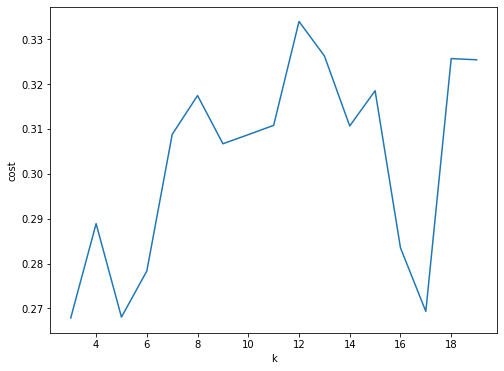

In [107]:
#Visualizing
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(3,20),evalresult)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [105]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 998 kB/s            
     |████████████████████████████████| 890 kB 732 kB/s            
  Using cached kiwisolver-1.3.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [109]:
kmeans=KMeans(featuresCol='features',
    predictionCol='prediction',
    k=12,
    initMode='k-means||',
    initSteps=2,
    tol=0.0001,
    maxIter=20,
    seed=None,
    distanceMeasure='euclidean')

In [110]:
kmodel=kmeans.fit(df).transform(df)

In [111]:
result=evaluator.evaluate(kmodel)

In [116]:
result

0.08406319367546175

In [117]:
kmodel.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 4126|
|         6|   60|
|         3|  322|
|         5|  280|
|         9| 2026|
|         4|  803|
|         8|    7|
|         7|   73|
|        10|    5|
|        11|   18|
|         2|  257|
|         0|  973|
+----------+-----+

